In [40]:
from vtl.Readfile import Readfile
from vtl.Photo import Photometry
from spec_id import Gauss_dist, Gen_spec, Calzetti
from astropy.table import Table
from astropy.io import fits
import astropy.units as u
import os
from astropy.cosmology import Planck13, z_at_value
from scipy.interpolate import interp1d, interp2d
from scipy.ndimage import interpolation
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.animation as animation
import matplotlib.image as mpimg
from mpl_toolkits.axes_grid.inset_locator import inset_axes
import rpy2
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
R = robjects.r
from glob import glob
import seaborn as sea
import numpy as np
import pandas as pd
sea.set(style='white')
sea.set(style='ticks')
sea.set_style({'xtick.direct'
               'ion': 'in','xtick.top':True,'xtick.minor.visible': True,
               'ytick.direction': "in",'ytick.right': True,'ytick.minor.visible': True})
colors = [(0,i,i,i) for i in np.linspace(0,1,3)]
cmap = sea.cubehelix_palette(12, start=2, rot=.2, dark=0, light=1.2, as_cmap=True)
pandas2ri.activate()

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

### set home for files
hpath = os.environ['HOME'] + '/'

In [32]:
galDB = pd.read_pickle('../data/upd_galDB.pkl')
lzDB = galDB.query('z_grism < 1.16')
mzDB = galDB.query('1.16 < z_grism < 1.3')
hzDB = galDB.query('1.3 < z_grism < 1.45')
uhzDB = galDB.query('1.45 < z_grism')


metal=np.round(np.arange(0.002,0.031,0.001),3)
age=np.round(np.arange(.5,6.1,.1),1)
tau=[0,8.0, 8.3, 8.48, 8.6, 8.7, 8.78, 8.85, 8.9, 8.95, 9.0, 9.04, 9.08, 9.11, 9.15, 9.18, 9.2, 9.23, 9.26, 9.28,
     9.3, 9.32, 9.34, 9.36, 9.38, 9.4, 9.41, 9.43, 9.45, 9.46, 9.48]
dust=np.round(np.arange(0.0,1.1,0.1),1)
M,A=np.meshgrid(metal,age)

In [7]:
def Gen_2d_gauss(gridsize,mu,sig):
    grid_range = np.arange(gridsize)
    g=Gauss_dist(grid_range,mu,sig)
    grid = np.ones([gridsize,gridsize])

    for i in range(len(grid)):
        grid[i] *= g

    for i in range(len(grid)):
        grid.T[i] *= g

    return np.array(grid).astype(np.float32)

In [9]:
sp = Gen_spec('n21156',1.249)

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3422: RuntimeWarning: invalid value encountered in sqrt
  resid = np.abs(self.scif - self.flat_flam)*np.sqrt(self.ivarf)
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3427: RuntimeWarning: invalid value encountered in sqrt
  contam_mask = ((self.contam*np.sqrt(self.ivar) > contam_sn_mask[0]) &
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3428: RuntimeWarning: invalid value encountered in sqrt
  (self.model*np.sqrt(self.ivar) < contam_sn_mask[1]))
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: divide by zero encountered in true_divide
  self.op

In [31]:
sigs = np.arange(.1,3.1,.1)

sp = Gen_spec('n21156',1.249)
mod = np.max(sp.beam.beam.direct)

for i in range(len(sigs)):
    grid = Gen_2d_gauss(150,75,sigs[i])
    grid /= (mod/ np.max(grid))
    sp.beam.beam.direct = grid
    
    gs = gridspec.GridSpec(1,2,width_ratios=[1,2.5],wspace=0)

    plt.figure(figsize=[20,5])
    plt.subplot(gs[0])
    plt.imshow(grid[40:111,40:111])
    plt.gca().tick_params(axis='y',labelleft='off')
    plt.gca().tick_params(axis='x',labelbottom='off')
    

    sp.Sim_spec(0.019,2.5,8.0)

    plt.subplot(gs[1])
    plt.plot(sp.gal_wv,sp.fl*1E18, linewidth=3)
    plt.gca().tick_params(axis='y',labelleft='off')
    plt.tick_params(axis='both', which='major', labelsize=23,length = 7, width=2)
    plt.savefig('../plots/morph_plots/morph_plot_{0}.png'.format(i),bbox_inches = 'tight')
    plt.close()

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3422: RuntimeWarning: invalid value encountered in sqrt
  resid = np.abs(self.scif - self.flat_flam)*np.sqrt(self.ivarf)
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3427: RuntimeWarning: invalid value encountered in sqrt
  contam_mask = ((self.contam*np.sqrt(self.ivar) > contam_sn_mask[0]) &
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3428: RuntimeWarning: invalid value encountered in sqrt
  (self.model*np.sqrt(self.ivar) < contam_sn_mask[1]))
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: divide by zero encountered in true_divide
  self.op

In [35]:
def Color(band1,band2):
    return -2.5*np.log10(band1/band2)

In [36]:
uv=[]
vj=[]
for i in age:
    wv,fl = np.load(hpath + 'fsps_models_for_fit/fsps_spec/m0.019_a{0}_dt0_spec.npy'.format(i))

#     dust = Calzetti(galDB.dx[i],wv)
#     dust2 = Calzetti2(galDB.dx[i],wv)

#     for ii in range(len(dust)):
#         if wv[ii] > 6300:
#             dust[ii]=dust2[ii]  
    
#     fl *= dust
    
    phot = Photometry(wv,fl,np.ones(wv.size),153)
    phot.Get_Sensitivity()
    phot.Photo()
    u_eff,u_phot = phot.eff_wv,phot.photo
    phot.Get_Sensitivity(155)
    phot.Photo()
    v_eff,v_phot = phot.eff_wv,phot.photo
    phot.Get_Sensitivity(161)
    phot.Photo()
    j_eff,j_phot = phot.eff_wv,phot.photo

    uv.append(Color(u_eff **2 *u_phot,v_eff **2 *v_phot))
    vj.append(Color(v_eff **2 *v_phot,j_eff **2 *j_phot))

In [41]:
def Calzetti2(Av,lam):
    lam = lam * 1E-4
    Rv=4.05
    k = 2.659*(-1.857 +1.04/(lam)) + Rv
    cal = 10**(-0.4*k*Av/Rv)    
    
    return cal

uvd=[]
vjd=[]
wv,fl = np.load(hpath + 'fsps_models_for_fit/fsps_spec/m0.019_a0.5_dt0_spec.npy')

for i in np.arange(0,1.6,.1):

    dust = Calzetti(i,wv)
    dust2 = Calzetti2(i,wv)

    for ii in range(len(dust)):
        if wv[ii] > 6300:
            dust[ii]=dust2[ii]  
    
    fl *= dust
    
    phot = Photometry(wv,fl,np.ones(wv.size),153)
    phot.Get_Sensitivity()
    phot.Photo()
    u_eff,u_phot = phot.eff_wv,phot.photo
    phot.Get_Sensitivity(155)
    phot.Photo()
    v_eff,v_phot = phot.eff_wv,phot.photo
    phot.Get_Sensitivity(161)
    phot.Photo()
    j_eff,j_phot = phot.eff_wv,phot.photo

    uvd.append(Color(u_eff **2 *u_phot,v_eff **2 *v_phot))
    vjd.append(Color(v_eff **2 *v_phot,j_eff **2 *j_phot))

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/matplotlib/cbook/__init__.py:2446: UserWarning: Saw kwargs ['lw', 'linewidth'] which are all aliases for 'linewidth'.  Kept value from 'linewidth'
  seen=seen, canon=canonical, used=seen[-1]))


[0, 2.5, 0.5, 2.5]

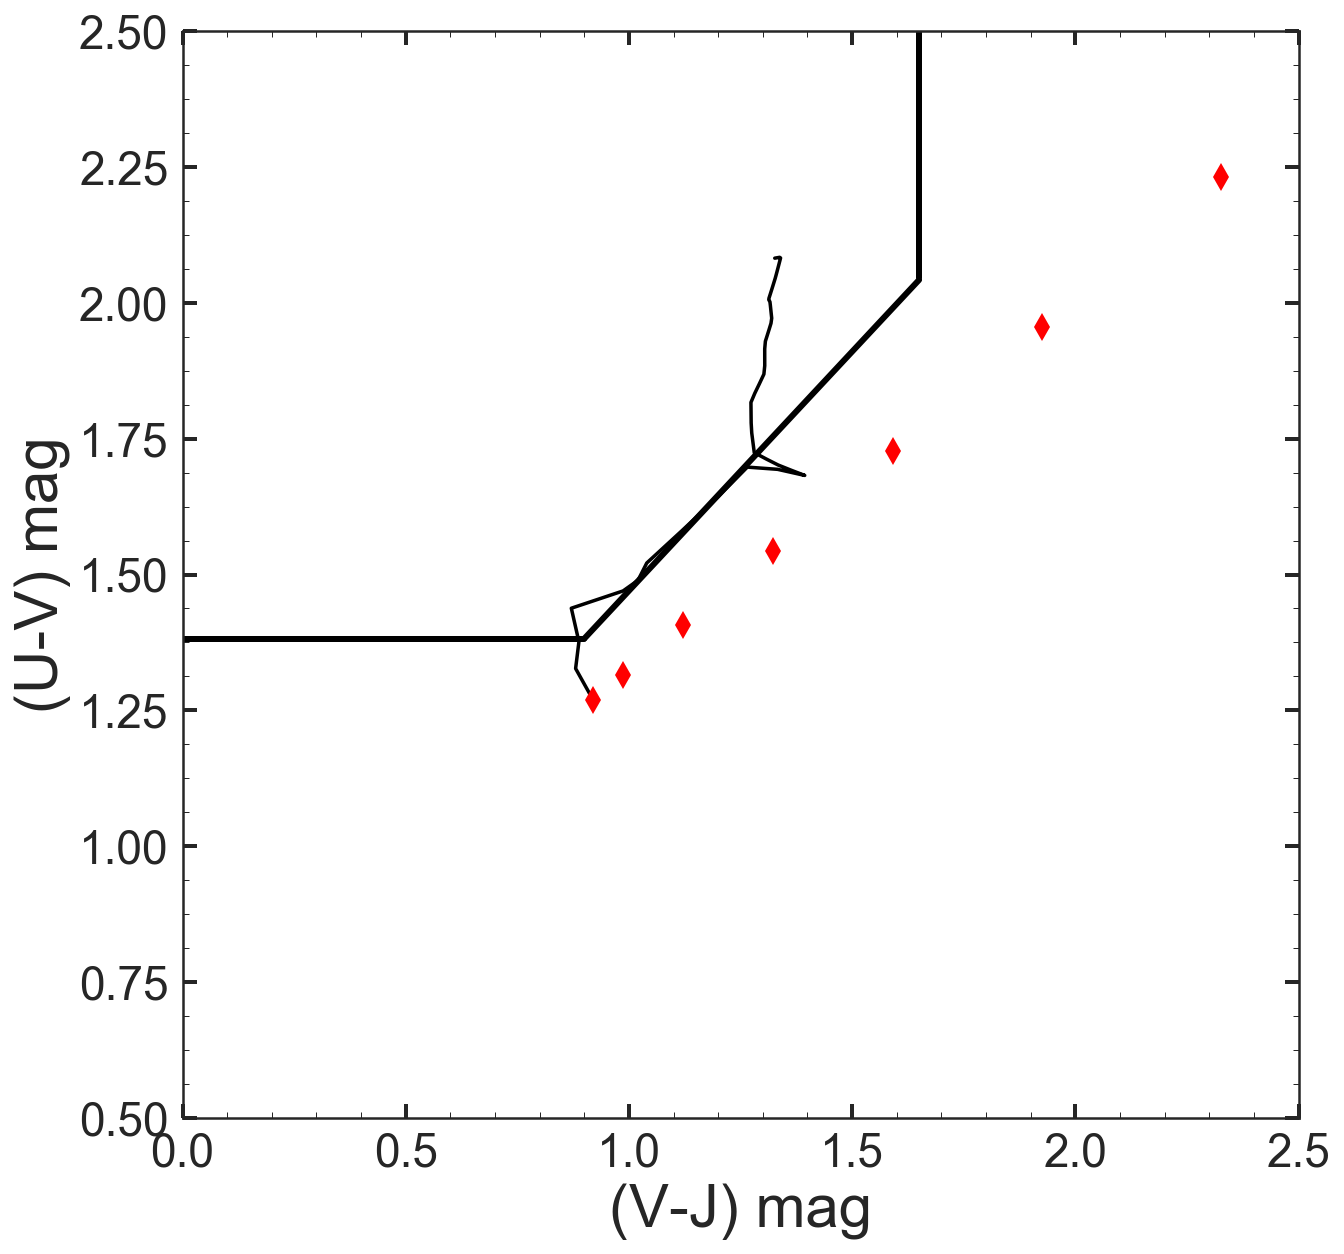

In [43]:
plt.figure(figsize=[10,10])
plt.plot(vj,uv,'k',ms=10)
plt.plot(vjd,uvd,'rd',ms=10)

plt.plot([0,.9],[1.382,1.382],'k',lw=.9,linewidth=3)
plt.plot([1.65,1.65],[2.045,2.5],'k',lw=.9,linewidth=3)
plt.plot([.9,1.65],[0.88*.9+0.59,0.88*1.65+0.59],'k',lw=.9,linewidth=3)
plt.xlabel('(V-J) mag',fontsize=30)
plt.ylabel('(U-V) mag',fontsize=30)
plt.tick_params(axis='both', which='major', labelsize=23,length = 7, width=2)
plt.minorticks_on()
plt.axis([0,2.5,.5,2.5])


# features plot

In [73]:
spec1 = Gen_spec('s39170', 1.0,minwv=7800,maxwv=11500,tmp_err=False)
# spec2 = Gen_spec('s39170', 1.23,maxwv=11450)
# spec3 = Gen_spec('s39170', 1.375,maxwv=11450)
spec6 = Gen_spec('s39170', 1.8,minwv=7800,maxwv=11500,tmp_err=False)
spec1.Sim_spec(0.019,2.5,8.0)
# spec2.Sim_spec(galDB['Z_lwa'][220],galDB['t_lwa'][220],8.48)
# spec3.Sim_spec(galDB['Z_lwa'][220],galDB['t_lwa'][220],8.48)
spec6.Sim_spec(0.019,2.5,8.0)


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.7.0-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3420: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.7.0-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3449: RuntimeWarning: invalid value encountered in sqrt
  resid = np.abs(self.scif - self.flat_flam)*np.sqrt(self.ivarf)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.7.0-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3454: RuntimeWarning: invalid value encountered in sqrt
  contam_mask = ((self.contam*np.sqrt(self.ivar) > contam_sn_mask[0]) &
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.7.0-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3455: RuntimeWarning: invalid value encountered in sqrt
  (self.model*np.sqrt(self.ivar) < contam_sn_mask[1]))
/Users/vestrada/mi

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


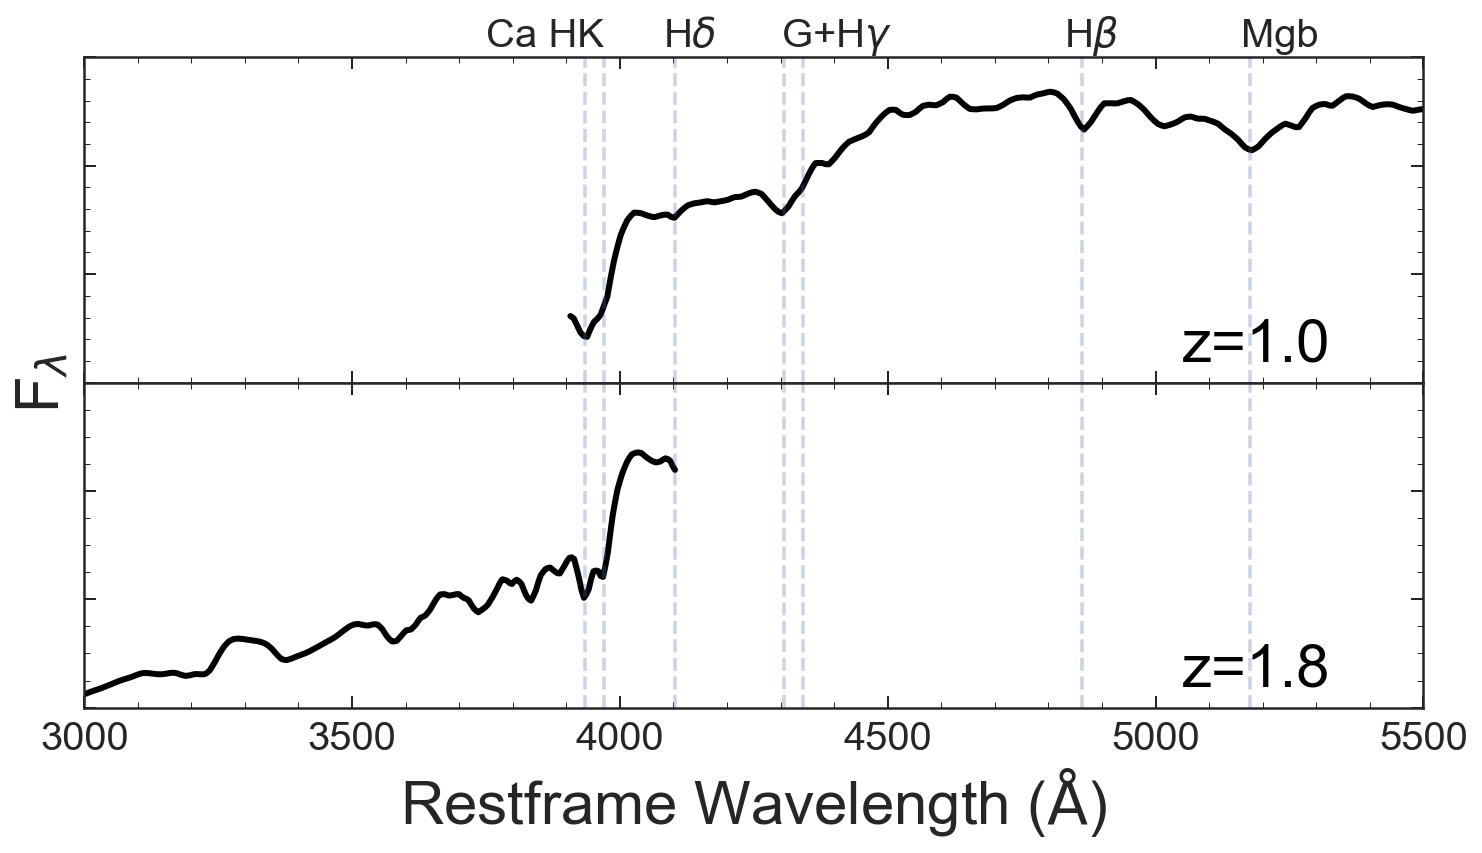

In [94]:
###PLOT###PLOT
%matplotlib inline

gs = gridspec.GridSpec(2,1,wspace=0,hspace=0)

plt.figure(figsize=(12,7))
plt.subplot(gs[0])
plt.plot(spec1.gal_wv_rf,spec1.fl*1E18, color='k', linewidth=3)
plt.xlim(3000,5500)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.gcf().subplots_adjust(bottom=0.235)
plt.axvline(3934.777,linestyle='--', alpha=.3)
plt.axvline(3969.588,linestyle='--', alpha=.3)
plt.axvline(4102.89,linestyle='--', alpha=.3)
plt.axvline(4305.61,linestyle='--', alpha=.3)
plt.axvline(4341.68,linestyle='--', alpha=.3)
plt.axvline(4862.68,linestyle='--', alpha=.3)
plt.axvline(5176.7,linestyle='--', alpha=.3)
plt.text(3750,5.1,'Ca HK',fontsize=20)
plt.text(4080,5.1,'H$\delta$',fontsize=20)
plt.text(4300,5.1,'G+H$\gamma$',fontsize=20)
plt.text(4830,5.1,'H$\\beta$',fontsize=20)
plt.text(5160,5.1,'Mgb',fontsize=20)
plt.gca().tick_params(axis='x',labelbottom='off')
plt.gca().tick_params(axis='y',labelleft='off')
txt = plt.text(5050,2.2,'z=1.0', fontsize=30, color='k')
plt.ylim(2,5)
plt.minorticks_on()

plt.subplot(gs[1])
plt.plot(spec6.gal_wv_rf,spec6.fl*1E18, color='k', linewidth=3)
plt.xlim(3000,5500)
plt.ylabel('F$_\lambda$',size=30, position=(3000,1))
plt.gca().tick_params(axis='y',labelleft='off')
plt.tick_params(axis='both', which='major', labelsize=20)
plt.gcf().subplots_adjust(bottom=0.235)
plt.axvline(3934.777,linestyle='--', alpha=.3)
plt.axvline(3969.588,linestyle='--', alpha=.3)
plt.axvline(4102.89,linestyle='--', alpha=.3)
plt.axvline(4305.61,linestyle='--', alpha=.3)
plt.axvline(4341.68,linestyle='--', alpha=.3)
plt.axvline(4862.68,linestyle='--', alpha=.3)
plt.axvline(5176.7,linestyle='--', alpha=.3)
txt = plt.text(5050,2.4,'z=1.8', fontsize=30, color='k')
plt.minorticks_on()
plt.ylim(2,8)
plt.xlabel('Restframe Wavelength ($\\rm \AA$)',size=30)
plt.gca().tick_params(axis='y',labelleft='off')

plt.savefig('../plots/spec_groups_diff.png',bbox_inches = 'tight')